# Importação

## Leitura

In [16]:
# o pandas é usado para ler e manipular os dados das nossas bases (os arquivos)
import pandas as pd

# o train_test_split é usado para separar a base de treino e a base de teste
# o GridSearchCV é usado para escolher os melhores parâmetros para o modelo
from sklearn.model_selection import train_test_split, GridSearchCV

## Modelo
Aqui são importadas as classes dos modelos que serão testados

In [17]:
# árvore de decisão
from sklearn.tree import DecisionTreeClassifier

# naive baeys
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

# serialização
import pickle as pkl

### Avaliação do modelo

In [18]:
# reporte de classificação
# matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix

# Treinamento do modelo

## Leitura do DataFrame

In [19]:
# Lendo e juntando os dois arquivos
df = pd.concat([pd.read_csv('FORMS 2/base_tratada_forms_2.csv').loc[:, 'age':], pd.read_csv('FORMS 1/treated_df.csv').loc[:, 'age':]]).drop(columns=['is_lgbt']).dropna()
df

,age,gender,time_in_social_media,people_living_together,social_class,has_pets,number_of_pets,has_dog,has_cat,has_others,forgets,report_abandoned,feeling,would_use
1,17,1,3.0,3,2.0,0,0.0,0,0,0,1,4,3.0,1.0
2,47,1,2.0,3,2.0,0,0.0,0,0,0,1,4,3.0,1.0
3,17,1,2.0,4,2.0,1,2.0,1,1,0,1,4,5.0,1.0
4,16,0,2.0,3,4.0,1,1.0,1,0,0,1,4,3.0,0.0
5,11,2,5.0,4,2.0,1,1.0,1,0,0,1,2,5.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,40,1,2.0,4,3.0,1,2.0,0,0,0,0,4,3.0,0.0
350,50,1,2.0,2,3.0,1,1.0,1,0,0,0,3,3.0,1.0
351,40,1,2.0,3,3.0,1,1.0,1,0,0,1,4,3.0,1.0
352,50,0,0.0,2,3.0,0,0.0,0,0,0,1,2,3.0,1.0


In [20]:
df.loc[df['would_use'] == 0.5, 'would_use'] = 1
# df = df.loc[df['would_use'] != 0.5]

#### Balanceamento

In [21]:
df.groupby('would_use').size()

would_use
0.0    136
1.0    475
dtype: int64

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'gender'),
 Text(2.5, 0, 'time_in_social_media'),
 Text(3.5, 0, 'people_living_together'),
 Text(4.5, 0, 'social_class'),
 Text(5.5, 0, 'has_pets'),
 Text(6.5, 0, 'number_of_pets'),
 Text(7.5, 0, 'has_dog'),
 Text(8.5, 0, 'has_cat'),
 Text(9.5, 0, 'has_others'),
 Text(10.5, 0, 'forgets'),
 Text(11.5, 0, 'report_abandoned'),
 Text(12.5, 0, 'feeling'),
 Text(13.5, 0, 'would_use')]

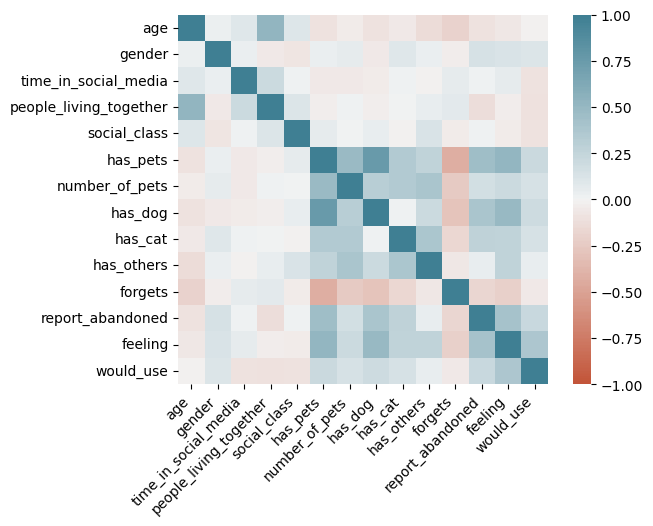

In [22]:
import seaborn as sns
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [23]:
filtered_df = df[df['would_use'] == 1]

df = pd.concat([filtered_df.groupby('would_use').sample(frac=0.28), df.loc[df['would_use'] == 0]], axis=0)

## Divisão do DataFrame

### Separação features e resposta

In [24]:
x = df.drop(columns=['would_use', 'feeling'])
y = df['would_use']

### Separação treino e teste

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## Treinamento

### Model Training pipeline

In [26]:
def model_training(model_name: str, x_train: pd.DataFrame, y_train, params: dict = None):
    '''
    # Pipeline de treino para o modelo
    Essa função já faz o treino automático do modelo, recebendo como parâmetros o nome do modelo, os parâmetros 
    # Parâmetros:
     - model_name - modelo que será usado [naive_baeys, decision_tree (árvore de decisão), knn]
     - x_train - DataFrame do pandas, com todas as features e os valores da base
     - y_train - Lista com as respostas de cada linha do x_train, na mesma ordem
     - params - dicionário com parâmetro:valor a ser usado no modelo, caso seja None, vai escolher os melhores parâmetros
    '''
    
    # Dicionário com os possíveis parâmetros para cada modelo (knn & tree)
    param_grid = {
        'decision_tree': { 'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': [None, 'sqrt', 'log2'], 'criterion': ['gini', 'entropy'] }, 
        'knn': { 'n_neighbors': range(2, (len(y_train)//2)+1), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
    }

    # Dicionário com os nomes dos modelos e suas classes
    models = {'naive_baeys':GaussianNB, 'decision_tree':DecisionTreeClassifier, 'knn': KNeighborsClassifier}

    # Definindo o modelo escolhido
    if model_name != 'naive_baeys':
        if params == None:
            model = models[model_name]()
            gs = GridSearchCV(estimator=model, param_grid=param_grid[model_name], scoring='accuracy', n_jobs=-1, cv=5)
            gs.fit(x_train, y_train)
            model = models[model_name](**gs.best_params_)
        else:
            model = models[model_name](**params)
    else:
        model = models[model_name]()
    
    model.fit(x_train, y_train)
    
    return model

### Model Testing Pipeline

In [27]:
def test(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(classification_report(y_pred=y_pred, y_true=y_test))
    return y_pred

### Naive Baeys

#### Treinando o modelo

In [44]:
naive_model = model_training('naive_baeys', x_train, y_train)

#### Testando o modelo

In [45]:
y_pred = test(naive_model, x_test, y_test)

              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76        34
         1.0       0.77      0.71      0.74        34

    accuracy                           0.75        68
   macro avg       0.75      0.75      0.75        68
weighted avg       0.75      0.75      0.75        68



### Decision Tree

#### Treinando o modelo

In [47]:
tree_model = model_training('decision_tree', x_train, y_train)

#### Testando o modelo

In [48]:
y_pred = test(tree_model, x_test, y_test)

              precision    recall  f1-score   support

         0.0       0.69      0.65      0.67        34
         1.0       0.67      0.71      0.69        34

    accuracy                           0.68        68
   macro avg       0.68      0.68      0.68        68
weighted avg       0.68      0.68      0.68        68



In [49]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[22, 12],
       [10, 24]], dtype=int64)

### KNN

#### Treinando o modelo

In [50]:
knn_model = model_training('knn', x_train, y_train)

#### Testando o modelo

In [51]:
y_pred = test(knn_model, x_test, y_test)

              precision    recall  f1-score   support

         0.0       0.62      0.44      0.52        34
         1.0       0.57      0.74      0.64        34

    accuracy                           0.59        68
   macro avg       0.60      0.59      0.58        68
weighted avg       0.60      0.59      0.58        68



# Serialização

### Como o modelo com melhor performance foi o Naive Baeys, ele será serializado.

In [54]:
with open('model_user.pkl ', 'wb') as f:
    pkl.dump(naive_model, f)